In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt   

from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from datret.datret import DatRetClassifier

2023-06-04 19:42:16.719137: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 19:42:18.409554: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-04 19:42:18.409631: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-04 19:42:18.409638: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [3]:
def read_transform_indicator(filename):
    df = pd.read_csv(filename)
    Y = df.Label
    X = df.drop(['Unnamed: 0', 'Label'], axis=1)
    del df

    X['Attack'] = X['Attack'].astype("string")
    attack_type = X['Attack']
    X = X.drop('Attack', axis=1)

    X = X.drop(['SimillarHTTP'], axis=1)
    
    X.loc[X['Flow Bytes/s'].isnull(), 'Flow Bytes/s'] = 0
    X.loc[X['Flow Bytes/s'] == np.inf, 'Flow Bytes/s'] = 0
    
    X.loc[X[' Flow Packets/s'].isnull(), ' Flow Packets/s'] = 0
    X.loc[X[' Flow Packets/s'] == np.inf, ' Flow Packets/s'] = 0

    return X, Y, attack_type

def scale(X):
    pass

In [4]:
X, Y, attack_type = read_transform_indicator('data/validation-set/nfuq-tiny.csv')

In [5]:
X = X.drop('mask', axis=1)

In [6]:
for col in X.columns:
    if np.any(np.isnan(X[col])) or not np.all(np.isfinite(X[col])):
        print(col)

In [7]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [8]:
def get_metrics(clf, X, Y, verbal=False):
    acc = accuracy_score(Y, clf.transform(X))
    
    if verbal:
        print(f"accuracy: {acc}")
        
        tn, fp, fn, tp = confusion_matrix(Y, clf.transform(X)).ravel()

        ax= plt.subplot()
        sns.heatmap([[tn, fp],[fn, tp]], annot=True, fmt='g', ax=ax)

        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.set_title('Confusion Matrix')
        ax.xaxis.set_ticklabels(['benign', 'malicious']); ax.yaxis.set_ticklabels(['benign', 'malicious'])
        plt.show()
    return acc

In [9]:
def eval_model(model, X, Y, n_splits=5, verbal=False):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    acc_total = 0
    for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
        print(f"Fold {i}:")
        model.fit(X[train_index], Y[train_index])
        acc = get_metrics(model, X[test_index], Y[test_index], verbal)
        print (f"Accuracy test: {acc}")
        acc_total +=  acc / n_splits 
    return acc_total

In [10]:
class WrapperCatboost(BaseEstimator, TransformerMixin):
    def setBoost(self, model, steps):
        self.model = model
        self.steps = steps
    def fit(self, X, Y):
        self.model.fit(X, Y, verbose = False, early_stopping_rounds=self.steps)
        return self
    def transform(self, X):
        return self.model.predict(X)
    

In [9]:
CBC = CatBoostClassifier()

In [10]:
parameters = {
    'random_seed'   : [42],
    'depth'         : [2, 3, 4, 5, 6],
    'learning_rate' : [0.01, 0.05, 0.1, 0.2, 0.3],
    'iterations'    : [100, 200, 400, 1000],
    'subsample'     : [0.85, 0.95, 1],
    'verbose'       : [False]
}

In [11]:
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 5, n_jobs=-1)
Grid_CBC.fit(X, Y)

KeyboardInterrupt: 

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

In [12]:
X

array([[0.        , 0.        , 0.        , ..., 0.99851357, 0.86666667,
        0.5       ],
       [0.        , 0.        , 0.        , ..., 0.17751352, 0.13333333,
        0.5       ],
       [0.        , 0.        , 0.        , ..., 0.35502705, 0.22222222,
        0.5       ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [13]:
catWrap = WrapperCatboost()
cat = CatBoostClassifier(depth=6, learning_rate=0.2, random_seed=42, subsample=0.85)
catWrap.setBoost(cat, steps=1000)

Fold 0:
accuracy: 0.9961914668724728


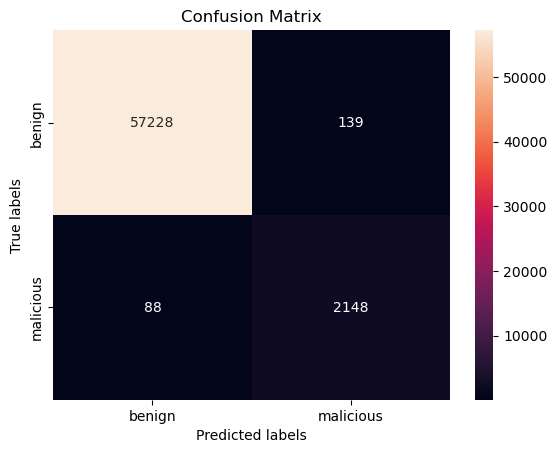

Accuracy test: 0.9961914668724728
Fold 1:
accuracy: 0.996644407905775


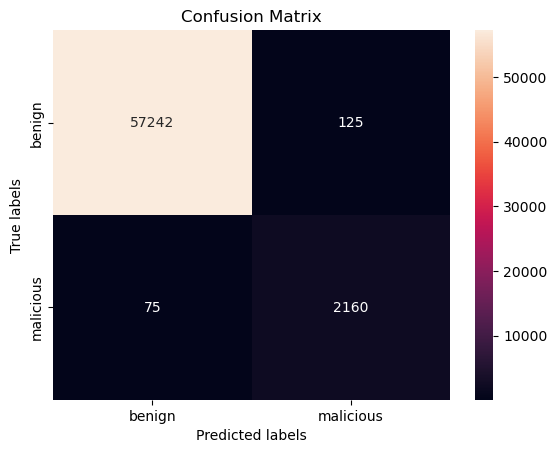

Accuracy test: 0.996644407905775
Fold 2:
accuracy: 0.996526962182477


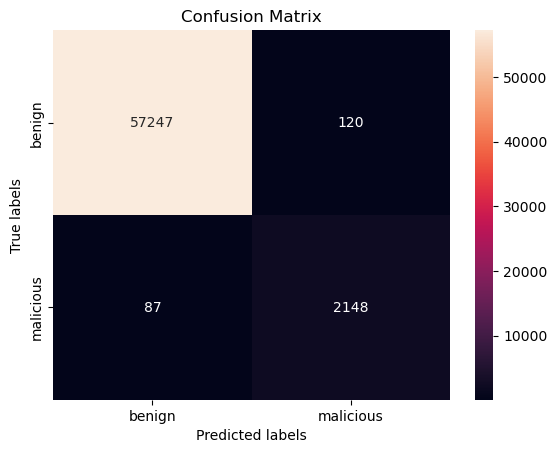

Accuracy test: 0.996526962182477
Fold 3:
accuracy: 0.9967450756686017


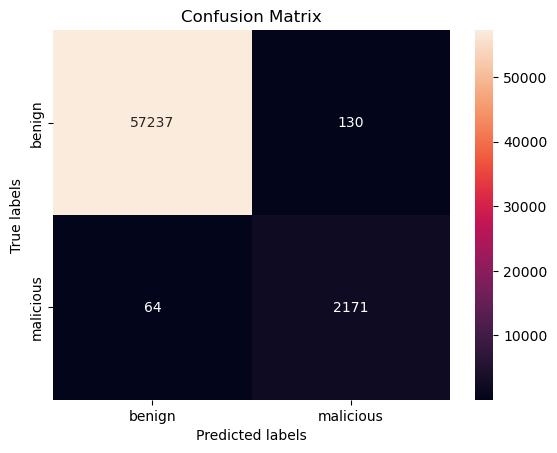

Accuracy test: 0.9967450756686017
Fold 4:
accuracy: 0.9965605181034194


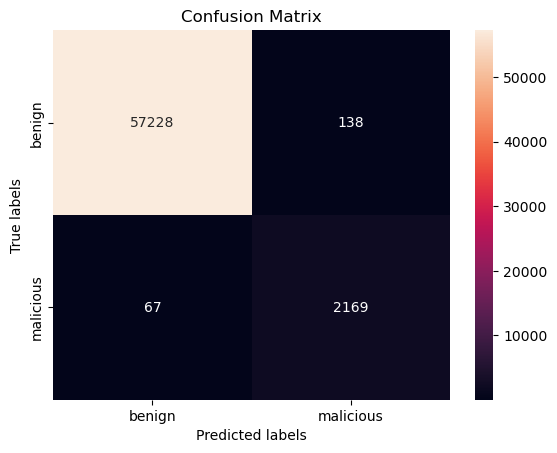

Accuracy test: 0.9965605181034194


0.9965336861465491

In [14]:
eval_model(catWrap, X, Y, n_splits=5, verbal=True)

In [17]:
class Data(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


class modelDNN(nn.Module):
    def __init__(self):
        super(modelDNN, self).__init__()        
        self.layer_1 = nn.Linear(111, 4096) 
        self.layer_2 = nn.Linear(4096, 2048)
        self.layer_3 = nn.Linear(2048, 1024) 
        self.layer_4 = nn.Linear(1024, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(4096)
        self.batchnorm2 = nn.BatchNorm1d(2048)
        self.batchnorm3 = nn.BatchNorm1d(1024)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.layer_4(x)
        
        return x

class tabularCNN(nn.Module):
    def __init__(self):
        super(tabularCNN, self).__init__()        
        self.layer_1 = nn.Linear(110, 1024) 
        self.layer_2 = nn.Linear(1024, 4096)
        self.layer_3 = nn.Linear(32*36, 1024) 
        self.layer_4 = nn.Linear(1024, 1) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(1024)
        self.batchnorm2 = nn.BatchNorm1d(4096)
        self.batchnorm3 = nn.BatchNorm1d(1024)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.conv_1 = nn.Conv2d(1, 32, 3)
        self.conv_2 = nn.Conv2d(32, 32, 3)
        self.conv_3 = nn.Conv2d(32, 32, 3)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        #print(x.shape)
        x = x.reshape(len(x), 1, 64, 64)
        x = self.pool(self.relu(self.conv_1(x)))
        x = self.pool(self.relu(self.conv_2(x)))
        x = self.pool(self.relu(self.conv_3(x)))
        #print(x.shape)
        x = x.reshape(len(x), 32*36)
        
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.layer_4(x)
        
        return x
    
def binary_acc(y_pred, y_test):

    y_pred_tag = torch.round(torch.sigmoid(y_pred))


    correct_results_sum = (y_pred_tag.detach().cpu().numpy().reshape(-1) == y_test.detach().cpu().numpy().reshape(-1)).sum()

    acc = correct_results_sum/y_test.shape[0]

    acc *= 100
    
    return acc

In [18]:
torch.FloatTensor(X)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.1125, 0.9985, 0.8667],
        [0.0000, 0.0000, 0.0000,  ..., 0.1125, 0.1775, 0.1333],
        [0.0000, 0.0000, 0.0000,  ..., 0.1125, 0.3550, 0.2222],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0708, 0.0000, 0.0000]])

In [19]:
class TransformData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight.data)

class WrapperTorch(BaseEstimator, TransformerMixin):
    def setModel(self, model, epochs, lr=0.005):
        self.epochs = epochs
        self.lr = lr
        self.device = torch.device("cuda:0")
        self.model = model.to(self.device)
        
    def fit(self, X, Y):
        for layer in self.model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        data = Data(torch.FloatTensor(X), torch.FloatTensor(Y.to_numpy()))
        del X, Y
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        loader = DataLoader(dataset=data, batch_size=512, shuffle=True)
        
        for e in range(self.epochs):
            epoch_acc = 0
            for X_batch, y_batch in loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                optimizer.zero_grad()

                y_pred = self.model(X_batch)

                loss = criterion(y_pred, y_batch.unsqueeze(1))
                acc = binary_acc(y_pred, y_batch.unsqueeze(1))
                epoch_acc += acc.item()

                loss.backward()
                optimizer.step()

            print(epoch_acc/len(loader))
        
        return self
    
    def transform(self, X):
        self.model.eval()
        
        return torch.round(torch.sigmoid(self.model(torch.FloatTensor(X).to(self.device)))).cpu().detach().numpy()

In [20]:
model = tabularCNN()
torchModel = WrapperTorch()
torchModel.setModel(model, 10)
eval_model(torchModel, X, Y, n_splits=3, verbal=False)

Fold 0:
96.57148977618935
97.16676492559175
97.20802451956878
97.29901167389266
97.27412958460276
97.30997883466135
97.35040536383876
97.27724213440356
97.38697782399812
97.41732518455589


OutOfMemoryError: CUDA out of memory. Tried to allocate 29.35 GiB (GPU 0; 7.92 GiB total capacity; 2.51 GiB already allocated; 3.66 GiB free; 2.93 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [189]:
model = tabularCNN()
torchModel = WrapperTorch()
torchModel.setModel(model, 10)
eval_model(torchModel, X, Y, n_splits=3, verbal=False)

Fold 0:


RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR

In [8]:
DR = DatRetClassifier()

In [9]:
def get_metrics_DR(clf, X, Y, verbal=False):
    acc = accuracy_score(Y, clf.predict(X))
    
    if verbal:
        print(f"accuracy: {acc}")
        
        tn, fp, fn, tp = confusion_matrix(Y, clf.predict(X)).ravel()

        ax= plt.subplot()
        sns.heatmap([[tn, fp],[fn, tp]], annot=True, fmt='g', ax=ax)

        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.set_title('Confusion Matrix')
        ax.xaxis.set_ticklabels(['benign', 'malicious']); ax.yaxis.set_ticklabels(['benign', 'malicious'])
        plt.show()
    return acc

def eval_DR(model, X, Y, n_splits=5, verbal=False):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    acc_total = 0
    for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
        print(f"Fold {i}:")
        model.fit(X[train_index], Y[train_index])
        acc = get_metrics_DR(model, X[test_index], Y[test_index], verbal)
        print (f"Accuracy test: {acc}")
        acc_total +=  acc / n_splits 
    return acc_total

In [10]:
eval_DR(DR, X, Y, n_splits=3, verbal=False)

Fold 0:
Epoch 1/50
12808/12808 [==============================] - 27s 2ms/step - loss: 0.0665 - lr: 0.0010
Epoch 2/50
12808/12808 [==============================] - 26s 2ms/step - loss: 0.0561 - lr: 0.0010
Epoch 3/50
12808/12808 [==============================] - 26s 2ms/step - loss: 0.0566 - lr: 0.0010
Epoch 4/50
12808/12808 [==============================] - 26s 2ms/step - loss: 0.0563 - lr: 0.0010
Epoch 5/50
12808/12808 [==============================] - ETA: 0s - loss: 0.0564
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
12808/12808 [==============================] - 26s 2ms/step - loss: 0.0564 - lr: 0.0010
Epoch 6/50
12808/12808 [==============================] - 26s 2ms/step - loss: 0.0520 - lr: 2.0000e-04
Epoch 7/50
12808/12808 [==============================] - 26s 2ms/step - loss: 0.0511 - lr: 2.0000e-04
Epoch 8/50
12808/12808 [==============================] - 26s 2ms/step - loss: 0.0513 - lr: 2.0000e-04
Epoch 9/50
12808/12808 [=================

KeyError: in user code:

    File "/home/nexei/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/nexei/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/nexei/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/nexei/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/nexei/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
        self.apply_gradients(grads_and_vars)
    File "/home/nexei/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "/home/nexei/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/nexei/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/nexei/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "/home/nexei/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1213, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "/home/nexei/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 216, in _update_step
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable dense/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.{self.__class__.__name__}.'


In [15]:
X_S, Y_s, attack_type = read_transform_indicator('data/validation-set/synth-tiny.csv')

In [17]:
X_S = X_S.drop('mask', axis=1)

X_S = scaler.transform(X_S)

In [24]:
np.sum(cat.predict(X_S) == Y_s)

5950

In [25]:
Y_s

0        0
1        0
2        0
3        0
4        0
        ..
11080    1
11081    1
11082    1
11083    1
11084    1
Name: Label, Length: 11085, dtype: int64